In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,5 Minutes,Lane 1 Flow (Veh/5 Minutes),# Lane Points,% Observed
0,04/01/2016 0:00,12,1,100
1,04/01/2016 0:05,13,1,100
2,04/01/2016 0:10,11,1,100
3,04/01/2016 0:15,13,1,100
4,04/01/2016 0:20,10,1,100


In [3]:
print(train_df.shape)
print(test_df.shape)

(7776, 4)
(4320, 4)


In [4]:
train_df.isna().sum()

5 Minutes                      0
Lane 1 Flow (Veh/5 Minutes)    0
# Lane Points                  0
% Observed                     0
dtype: int64

In [5]:
train_df['# Lane Points'].nunique()

1

In [6]:
train_df.dtypes

5 Minutes                      object
Lane 1 Flow (Veh/5 Minutes)     int64
# Lane Points                   int64
% Observed                      int64
dtype: object

In [7]:
train_df['5 Minutes'] = pd.to_datetime(train_df['5 Minutes'])
train_df.dtypes

5 Minutes                      datetime64[ns]
Lane 1 Flow (Veh/5 Minutes)             int64
# Lane Points                           int64
% Observed                              int64
dtype: object

In [8]:
train_df.head()

,5 Minutes,Lane 1 Flow (Veh/5 Minutes),# Lane Points,% Observed
0,2016-04-01 00:00:00,12,1,100
1,2016-04-01 00:05:00,13,1,100
2,2016-04-01 00:10:00,11,1,100
3,2016-04-01 00:15:00,13,1,100
4,2016-04-01 00:20:00,10,1,100


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_df['Lane 1 Flow (Veh/5 Minutes)'].values.reshape(-1, 1))
flow1 = scaler.transform(train_df['Lane 1 Flow (Veh/5 Minutes)'].values.reshape(-1, 1)).reshape(1, -1)[0]
flow2 = scaler.transform(test_df['Lane 1 Flow (Veh/5 Minutes)'].values.reshape(-1, 1)).reshape(1, -1)[0]

In [10]:
train, test = [], []
for i in range(12, len(flow1)):
    train.append(flow1[i - 12: i + 1])
for i in range(12, len(flow2)):
    test.append(flow2[i - 12: i + 1])

In [11]:
train = np.array(train)
test = np.array(test)
np.random.shuffle(train)

X_train = train[:, :-1]
y_train = train[:, -1]
X_test = test[:, :-1]
y_test = test[:, -1]

In [12]:
X_train.shape

(7764, 12)

In [13]:
X_test.shape

(4308, 12)

In [14]:
X_train

array([[0.4213198 , 0.54822335, 0.46700508, ..., 0.44670051, 0.40101523,
        0.36040609],
       [0.00507614, 0.05076142, 0.05076142, ..., 0.07614213, 0.07106599,
        0.08629442],
       [0.6751269 , 0.56852792, 0.49238579, ..., 0.43654822, 0.44670051,
        0.36548223],
       ...,
       [0.53807107, 0.52791878, 0.58375635, ..., 0.65482234, 0.52791878,
        0.46700508],
       [0.11167513, 0.11675127, 0.14720812, ..., 0.0964467 , 0.1319797 ,
        0.05076142],
       [0.05583756, 0.05583756, 0.05583756, ..., 0.01522843, 0.03045685,
        0.05583756]])

In [15]:
#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To calculate the mean squred error in predictions
def MSE_Value(test,predicted):
    mse = mean_squared_error(test, predicted)
    print("The mean squared error is {}.".format(mse))
    return mse

#To calculate the mean absolute error in predictions
def MAE_Value(test,predicted):
    mae = mean_absolute_error(test, predicted)
    print("The mean absolute error is {}.".format(mae))
    return mae

In [16]:
#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test,label="True Value",alpha=0.5 )
    plt.plot(predicted, label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

# Using RMSprop Opt With Sigmoid Activation

In [17]:
def GRUSigmoid_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    
    model.save('SigmoidModel.h5') # save the trained model to a file

    pred_GRU= model.predict(X_Test)

    return pred_GRU

In [18]:
PredSigmoid = GRUSigmoid_model(X_train,y_train,X_test)

Epoch 1/50
52/52 [==============================] - 17s 134ms/step - loss: 0.0867
Epoch 2/50
52/52 [==============================] - 6s 118ms/step - loss: 0.0462
Epoch 3/50
52/52 [==============================] - 6s 116ms/step - loss: 0.0449
Epoch 4/50
52/52 [==============================] - 6s 125ms/step - loss: 0.0440
Epoch 5/50
52/52 [==============================] - 7s 136ms/step - loss: 0.0440
Epoch 6/50
52/52 [==============================] - 7s 133ms/step - loss: 0.0439
Epoch 7/50
52/52 [==============================] - 7s 135ms/step - loss: 0.0436
Epoch 8/50
52/52 [==============================] - 7s 135ms/step - loss: 0.0435
Epoch 9/50
52/52 [==============================] - 7s 144ms/step - loss: 0.0436
Epoch 10/50
52/52 [==============================] - 7s 135ms/step - loss: 0.0435
Epoch 11/50
52/52 [==============================] - 7s 135ms/step - loss: 0.0435
Epoch 12/50
52/52 [==============================] - 7s 141ms/step - loss: 0.0433
Epoch 13/50
52/52 [=====

The root mean squared error is 0.20538756496566554.
The mean squared error is 0.04218405184252549.
The mean absolute error is 0.1778224730481075.


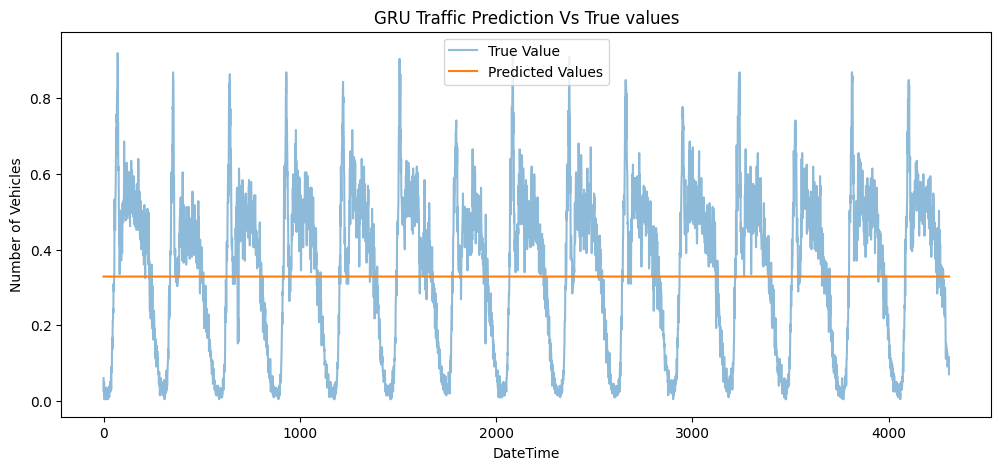

In [19]:
RMSE_Sigmoid=RMSE_Value(y_test,PredSigmoid)
MSE_Sigmoid=MSE_Value(y_test,PredSigmoid)
MAE_Sigmoid=MAE_Value(y_test,PredSigmoid)
PredictionsPlot(y_test,PredSigmoid,0)

# Using RMSprop with Tanh Activation

In [20]:
def RMSGRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    
    model.save('RMSmodel.h5') # save the trained model to a file

    pred_GRU= model.predict(X_Test)

    return pred_GRU

In [21]:
PredRMS = RMSGRU_model(X_train,y_train,X_test)

Epoch 1/50
52/52 [==============================] - 22s 130ms/step - loss: 0.0368
Epoch 2/50
52/52 [==============================] - 7s 126ms/step - loss: 0.0070
Epoch 3/50
52/52 [==============================] - 7s 129ms/step - loss: 0.0053
Epoch 4/50
52/52 [==============================] - 7s 133ms/step - loss: 0.0051
Epoch 5/50
52/52 [==============================] - 7s 127ms/step - loss: 0.0045
Epoch 6/50
52/52 [==============================] - 7s 132ms/step - loss: 0.0045
Epoch 7/50
52/52 [==============================] - 7s 134ms/step - loss: 0.0041
Epoch 8/50
52/52 [==============================] - 8s 147ms/step - loss: 0.0040
Epoch 9/50
52/52 [==============================] - 8s 155ms/step - loss: 0.0038
Epoch 10/50
52/52 [==============================] - 7s 141ms/step - loss: 0.0039
Epoch 11/50
52/52 [==============================] - 7s 137ms/step - loss: 0.0038
Epoch 12/50
52/52 [==============================] - 7s 137ms/step - loss: 0.0035
Epoch 13/50
52/52 [=====

The root mean squared error is 0.051802395830688665.
The mean squared error is 0.00268348821379935.
The mean absolute error is 0.038953299950823826.


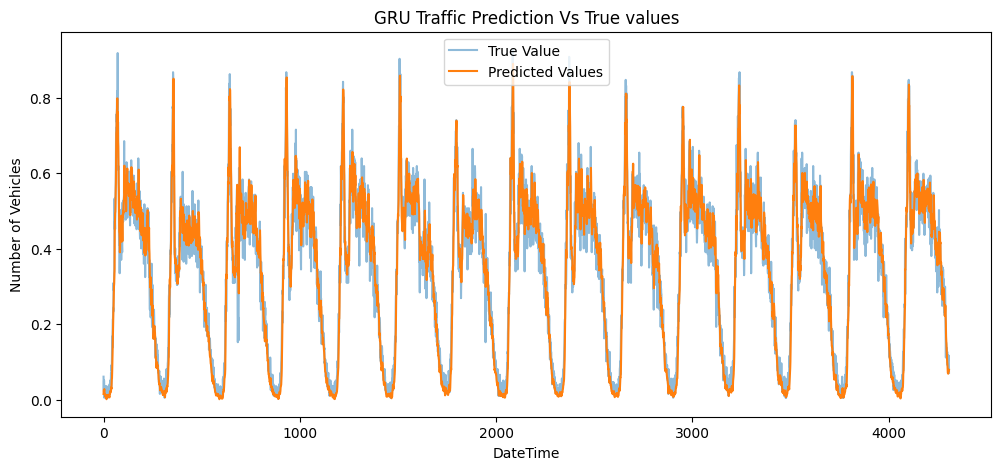

In [22]:
RMSE_RMS=RMSE_Value(y_test,PredRMS)
MSE_RMS=MSE_Value(y_test,PredRMS)
MAE_RMS=MAE_Value(y_test,PredRMS)
PredictionsPlot(y_test,PredRMS,0)

# Using SGD Opt with Tanh Activation

In [23]:
def SGDGRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=tf.keras.optimizers.legacy.SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    
    model.save('SGDmodel.h5') # save the trained model to a file

    pred_GRU= model.predict(X_Test)

    return pred_GRU

In [24]:
PredSGD = SGDGRU_model(X_train,y_train,X_test)

Epoch 1/50
52/52 [==============================] - 19s 130ms/step - loss: 0.0483
Epoch 2/50
52/52 [==============================] - 7s 125ms/step - loss: 0.0169
Epoch 3/50
52/52 [==============================] - 6s 123ms/step - loss: 0.0096
Epoch 4/50
52/52 [==============================] - 7s 126ms/step - loss: 0.0091
Epoch 5/50
52/52 [==============================] - 7s 128ms/step - loss: 0.0092
Epoch 6/50
52/52 [==============================] - 7s 129ms/step - loss: 0.0089
Epoch 7/50
52/52 [==============================] - 7s 125ms/step - loss: 0.0089
Epoch 8/50
52/52 [==============================] - 6s 124ms/step - loss: 0.0090
Epoch 9/50
52/52 [==============================] - 7s 126ms/step - loss: 0.0087
Epoch 10/50
52/52 [==============================] - 7s 127ms/step - loss: 0.0084
Epoch 11/50
52/52 [==============================] - 6s 125ms/step - loss: 0.0083
Epoch 12/50
52/52 [==============================] - 7s 125ms/step - loss: 0.0083
Epoch 13/50
52/52 [=====

The root mean squared error is 0.06980418671587146.
The mean squared error is 0.004872624483064246.
The mean absolute error is 0.05059367540660552.


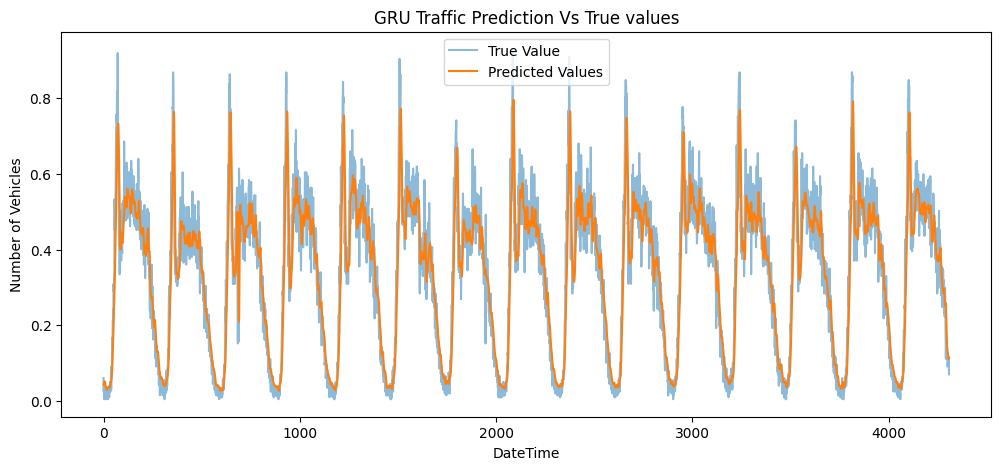

In [25]:
RMSE_SGD=RMSE_Value(y_test,PredSGD)
MSE_SGD=MSE_Value(y_test,PredSGD)
MAE_SGD=MAE_Value(y_test,PredSGD)
PredictionsPlot(y_test,PredSGD,0)

# Using ADAM Opt with Tanh Activation

In [26]:
def AdamGRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(decay=1e-7),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    
    model.save('ADAMmodel.h5') # save the trained model to a file

    pred_GRU= model.predict(X_Test)

    return pred_GRU

In [27]:
PredAdam = AdamGRU_model(X_train,y_train,X_test)

Epoch 1/50
52/52 [==============================] - 19s 121ms/step - loss: 0.0204
Epoch 2/50
52/52 [==============================] - 6s 123ms/step - loss: 0.0078
Epoch 3/50
52/52 [==============================] - 6s 121ms/step - loss: 0.0059
Epoch 4/50
52/52 [==============================] - 6s 122ms/step - loss: 0.0055
Epoch 5/50
52/52 [==============================] - 6s 123ms/step - loss: 0.0047
Epoch 6/50
52/52 [==============================] - 6s 121ms/step - loss: 0.0047
Epoch 7/50
52/52 [==============================] - 6s 122ms/step - loss: 0.0045
Epoch 8/50
52/52 [==============================] - 6s 124ms/step - loss: 0.0044
Epoch 9/50
52/52 [==============================] - 6s 123ms/step - loss: 0.0041
Epoch 10/50
52/52 [==============================] - 6s 122ms/step - loss: 0.0042
Epoch 11/50
52/52 [==============================] - 6s 122ms/step - loss: 0.0039
Epoch 12/50
52/52 [==============================] - 7s 130ms/step - loss: 0.0040
Epoch 13/50
52/52 [=====

The root mean squared error is 0.054571819702450765.
The mean squared error is 0.002978083505636793.
The mean absolute error is 0.04116038582570525.


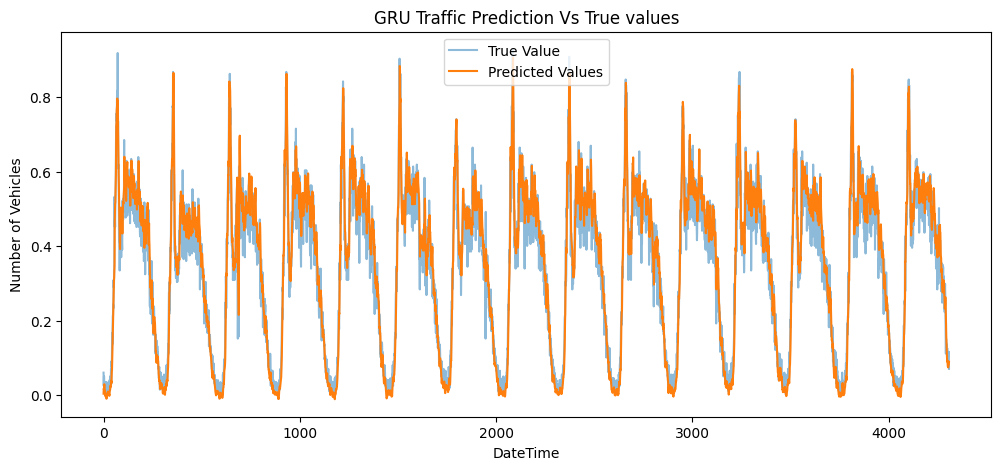

In [28]:
RMSE_ADAM=RMSE_Value(y_test,PredAdam)
MSE_ADAM=MSE_Value(y_test,PredAdam)
MAE_ADAM=MAE_Value(y_test,PredAdam)
PredictionsPlot(y_test,PredAdam,0)